In [1]:
import numpy as np
import matplotlib.pyplot as plt

def load_tensor_bin(filename):
    with open(filename, 'rb') as f:
        # 次元数 ndim (int64)
        ndim = np.fromfile(f, dtype=np.int64, count=1)[0]
        # 各軸のサイズ (int64 * ndim)
        shape = np.fromfile(f, dtype=np.int64, count=ndim)
        
        # Vec3<double> は double が3つ並んでいるため、
        # 最終的な shape は (num_grid, 3) になる
        data = np.fromfile(f, dtype=np.float64)
        
        # Vec3(x, y, z) の 3 成分を考慮して reshape
        return data.reshape((*shape, 3))

In [39]:
e_data_0 = load_tensor_bin("out/e0.bin")

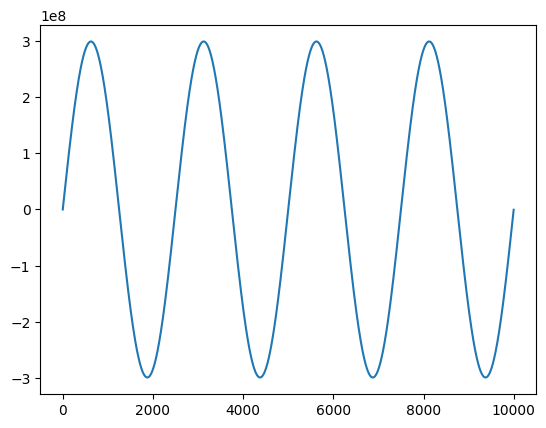

In [40]:
plt.plot(e_data_0[:,0])

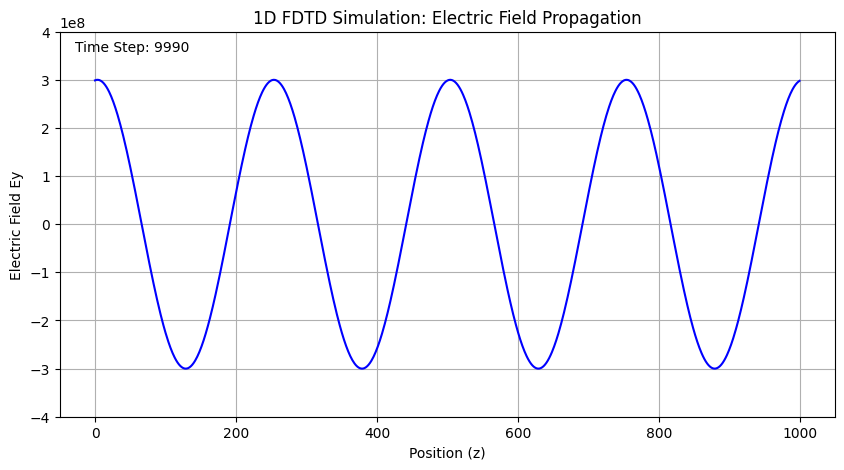

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os # ファイル存在チェック用

# load_tensor_bin 関数は前回と同じ
def load_tensor_bin(filename):
    with open(filename, 'rb') as f:
        ndim = np.fromfile(f, dtype=np.int64, count=1)[0]
        shape = np.fromfile(f, dtype=np.int64, count=ndim)
        data = np.fromfile(f, dtype=np.float64)
        return data.reshape((*shape, 3))

# --- 設定 ---
output_dir = "out"
total_frames = 10000 // 10 # C++の save_interval に合わせる (total_steps / save_interval)
# E_y 成分をアニメーション表示
component_index = 1 # 0: Ex, 1: Ey, 2: Ez

# 最初のフレームを読み込んでサイズを取得
first_file = os.path.join(output_dir, f"m0.bin")
if not os.path.exists(first_file):
    print(f"Error: {first_file} not found. Please run the C++ simulation first.")
    exit()

initial_data = load_tensor_bin(first_file)
num_grid = initial_data.shape[0]
z_coords = np.arange(num_grid)

# --- アニメーションの準備 ---
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot(z_coords, initial_data[:, component_index], color='blue')
ax.set_ylim(-4e8, 4e8) # Y軸の範囲を固定
ax.set_xlabel("Position (z)")
ax.set_ylabel(f"Electric Field E{'xyz'[component_index]}")
ax.set_title("1D FDTD Simulation: Electric Field Propagation")
ax.grid(True)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes) # 時刻表示

def update(frame):
    filename = os.path.join(output_dir, f"m{frame}.bin")
    if not os.path.exists(filename):
        print(f"Warning: {filename} not found. Stopping animation.")
        return line, time_text # Noneを返すとエラーになる可能性
    
    data = load_tensor_bin(filename)
    line.set_ydata(data[:, component_index])
    time_text.set_text(f'Time Step: {frame * (10)}') # C++のt%save_interval == 0と合わせる
    return line, time_text

# アニメーション作成
ani = animation.FuncAnimation(
    fig, update, frames=total_frames, blit=True, interval=50 # intervalはms単位
)

# Jupyter Notebook/Lab で表示する場合
# from IPython.display import HTML
# HTML(ani.to_jshtml()) # HTML形式で出力（ファイルサイズ大）

# GIF または MP4 として保存する場合 (別途 ffmpeg または imagemagick が必要)
ani.save('fdtd_1d_propagation.gif', writer='pillow', fps=20) # GIFとして保存
# ani.save('fdtd_1d_propagation.mp4', writer='ffmpeg', fps=30) # MP4として保存

plt.show()